In [ ]:
!git clone https://github.com/SenticNet/stress-detection

fatal: destination path 'stress-detection' already exists and is not an empty directory.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
import string

# Use pd.read_excel to read Excel files
data = pd.read_excel("/content/stress-detection/Reddit_Title.xlsx")
#data = data.rename(columns={'title': 'text'})
#data = data.rename(columns={'label': 'labels'})
# Display basic info
print("Dataset Information:")
data.info()
print("\nFirst 5 rows:")
print(data.head())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5556 entries, 0 to 5555
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   5556 non-null   object
 1   label   5556 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 86.9+ KB

First 5 rows:
                                               title  label
0  My aunt and uncle scoring their first gig as p...      0
1  How do I stop stressing about work when I'm at...      1
2  Meeting a fellow suicidal student in middle sc...      1
3  My brain feels literally numb. Is this depress...      1
4  A mother's reaction after seeing her son has p...      0


In [ ]:
print(data.isnull().sum())

title    0
label    0
dtype: int64


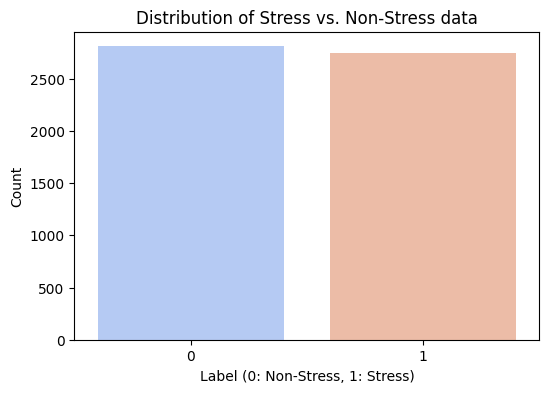

In [ ]:
# Label distribution
plt.figure(figsize=(6,4))
sns.countplot(x=data['label'], hue=data['label'], palette='coolwarm', legend=False)
plt.title("Distribution of Stress vs. Non-Stress data")
plt.xlabel("Label (0: Non-Stress, 1: Stress)")
plt.ylabel("Count")
plt.show()

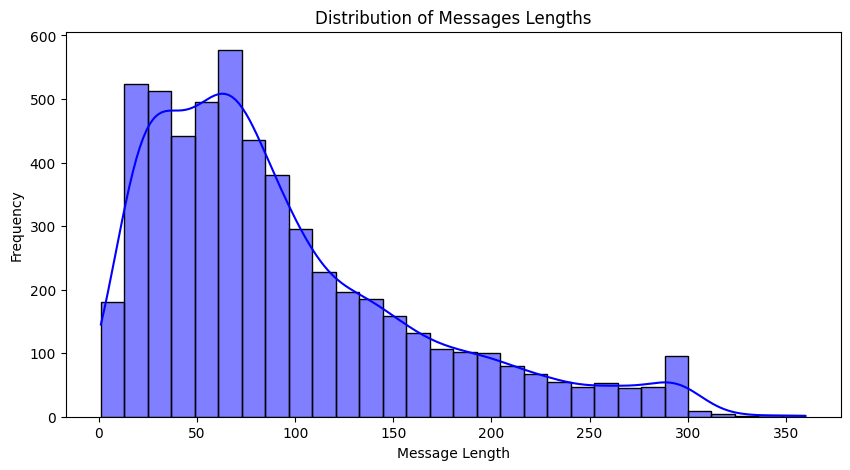

In [ ]:
# Tweet Length Distribution
data['message_length'] = data['title'].apply(len)
plt.figure(figsize=(10,5))
sns.histplot(data['message_length'], bins=30, kde=True, color='blue')
plt.xlabel("Message Length")
plt.ylabel("Frequency")
plt.title("Distribution of Messages Lengths")
plt.show()

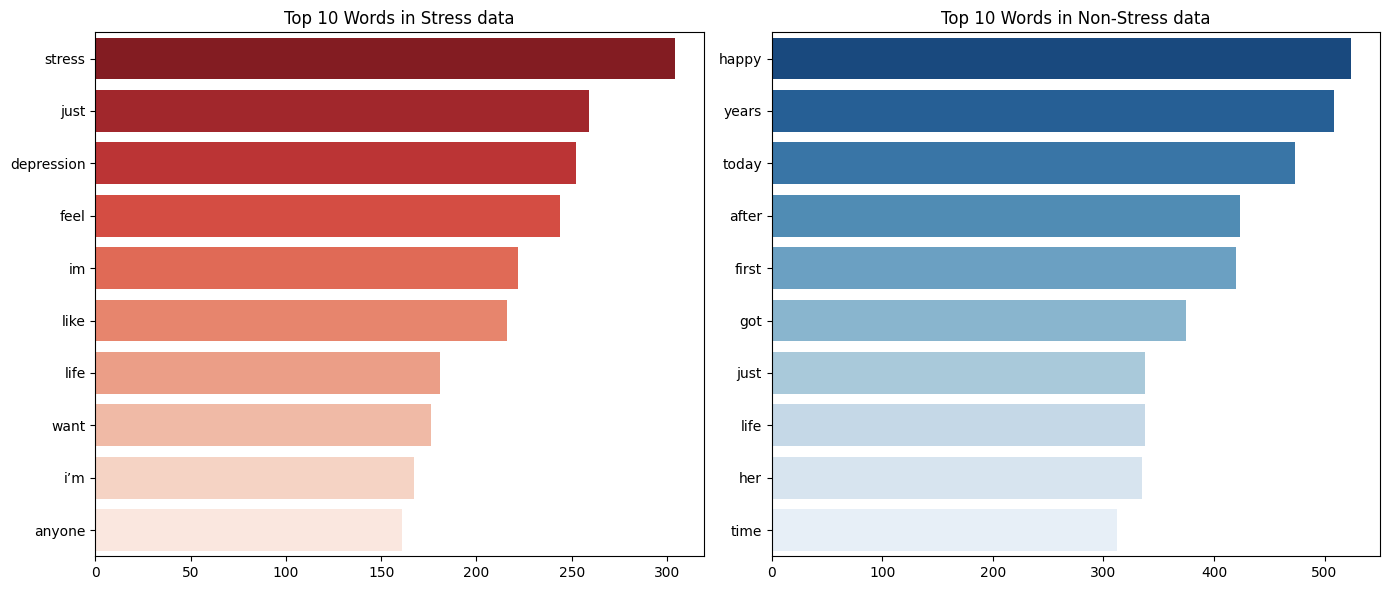

In [ ]:
# Custom stopwords list
custom_stopwords = set(["i", "me", "my", "we", "you", "your", "he", "she", "it", "they", "is", "are", "was", "were", "be", "been", "have", "has", "had", "do", "does", "did", "a", "an", "the", "and", "or", "but", "if", "as", "with", "for", "of", "to", "in", "on", "at", "by", "about", "that", "this", "these", "those", "there", "when", "where", "how", "all", "any", "more", "most", "some", "such", "only", "own", "so", "than", "too", "very"])

def preprocess_text(text):
    text = text.lower().translate(str.maketrans("", "", string.punctuation))  # Remove punctuation
    words = text.split()
    words = [word for word in words if word not in custom_stopwords]  # Remove stopwords
    return words

data["processed_message"] = data["title"].apply(preprocess_text)
# Most common words
stress_words = Counter([word for words in data[data['label'] == 1]['processed_message'] for word in words])
non_stress_words = Counter([word for words in data[data['label'] == 0]['processed_message'] for word in words])

# Plot top 10 words
stress_common = dict(stress_words.most_common(10))
non_stress_common = dict(non_stress_words.most_common(10))

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
sns.barplot(x=list(stress_common.values()), y=list(stress_common.keys()), ax=ax[0], hue=list(stress_common.keys()), palette='Reds_r', legend=False)
ax[0].set_title("Top 10 Words in Stress data")
sns.barplot(x=list(non_stress_common.values()), y=list(non_stress_common.keys()), ax=ax[1], hue=list(non_stress_common.keys()), palette='Blues_r', legend=False)
ax[1].set_title("Top 10 Words in Non-Stress data")
plt.tight_layout()
plt.show()

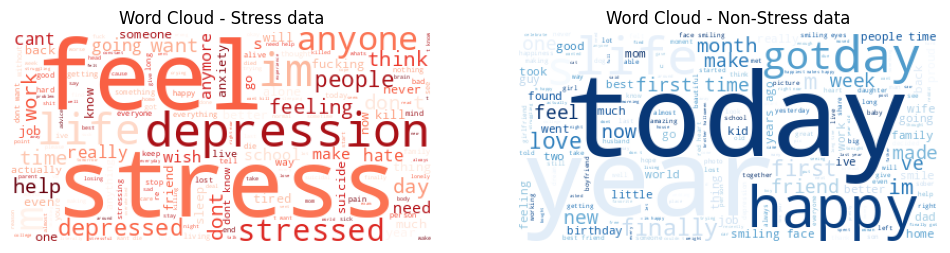

In [ ]:
# Generate Word Clouds
stress_text = ' '.join([' '.join(words) for words in data[data['label'] == 1]['processed_message']])
non_stress_text = ' '.join([' '.join(words) for words in data[data['label'] == 0]['processed_message']])

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(WordCloud(background_color='white', colormap='Reds').generate(stress_text))
plt.axis("off")
plt.title("Word Cloud - Stress data")

plt.subplot(1,2,2)
plt.imshow(WordCloud(background_color='white', colormap='Blues').generate(non_stress_text))
plt.axis("off")
plt.title("Word Cloud - Non-Stress data")
plt.show()

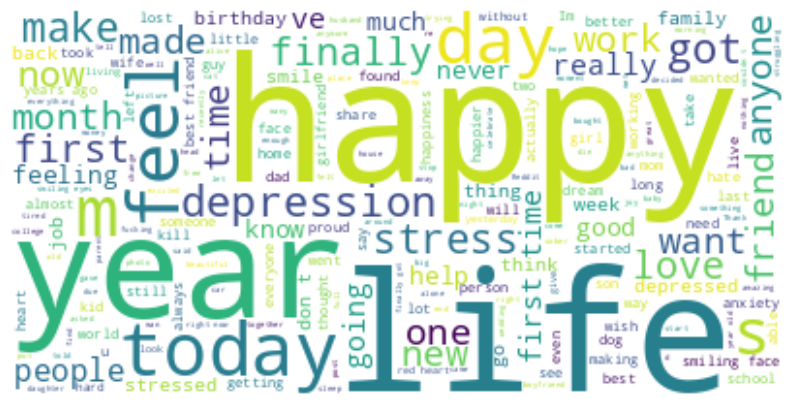

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
text = " ".join(i for i in data.title)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords,
                      background_color="white").generate(text)
plt.figure( figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
#3. Random Forest (Best Performing Model)
import nltk
import re
import string
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Download NLTK stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

stopword = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

def clean(text):
    text = str(text).lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>+', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'\w*\d\w*', '', text)
    text = " ".join([stemmer.stem(word) for word in text.split() if word not in stopword])
    return text
data["title"] = data["title"].apply(clean)
data["label"] = data["label"].map({0: "No Stress", 1: "Stress"})

'''# Shuffle dataset properly
data = data.sample(frac=1, random_state=42).reset_index(drop=True)'''

# Convert Text to Numerical Data
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(data["title"]).toarray()
y = data["label"].values

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

'''# Balance the dataset using SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)'''

# Optimized Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

# Evaluation Metrics
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Random Forest Accuracy: 0.89568345323741
Classification Report:
               precision    recall  f1-score   support

   No Stress       0.92      0.87      0.89       563
      Stress       0.87      0.92      0.90       549

    accuracy                           0.90      1112
   macro avg       0.90      0.90      0.90      1112
weighted avg       0.90      0.90      0.90      1112



In [ ]:
data = data[["title", "label"]]
print(data.head())

                                               title      label
0  aunt uncl score first gig profession taquero h...  No Stress
1                           stop stress work im home     Stress
2  meet fellow suicid student middl school chang ...     Stress
3                      brain feel liter numb depress     Stress
4              mother reaction see son pass bar exam  No Stress


In [ ]:
# Shuffle dataset properly
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

# Convert Text to Numerical Data
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(data["title"]).toarray()
y = data["label"].values

In [ ]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
#1. Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Train the model
lr = LogisticRegression()
lr.fit(X_train, y_train)

# Predictions
y_pred = lr.predict(X_test)

# Evaluate
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Logistic Regression Accuracy: 0.9280575539568345
              precision    recall  f1-score   support

   No Stress       0.95      0.91      0.93       563
      Stress       0.91      0.95      0.93       549

    accuracy                           0.93      1112
   macro avg       0.93      0.93      0.93      1112
weighted avg       0.93      0.93      0.93      1112



In [ ]:
#2. Decision Tree
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))

Decision Tree Accuracy: 0.8660071942446043
              precision    recall  f1-score   support

   No Stress       0.88      0.85      0.87       563
      Stress       0.85      0.88      0.87       549

    accuracy                           0.87      1112
   macro avg       0.87      0.87      0.87      1112
weighted avg       0.87      0.87      0.87      1112



In [ ]:
# Predict new text
new_text = ["I'm feeling DEPRESSED"]
new_text_clean = [clean(t) for t in new_text]
new_text_vectorized = vectorizer.transform(new_text_clean).toarray()

# Predict stress level
prediction = rf_model.predict(new_text_vectorized)
print("Predicted Stress Level:", "Stress" if prediction[0] == "Stress" else "No Stress")

Predicted Stress Level: Stress


In [ ]:
import numpy as np
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))

{'No Stress': 2248, 'Stress': 2196}


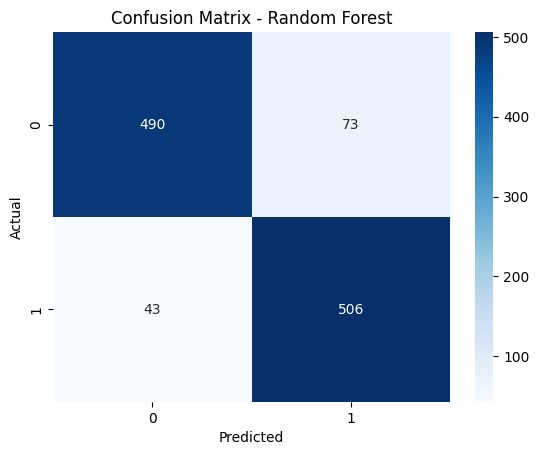

In [ ]:
# Evaluate Model Performance
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest')
plt.show()

In [ ]:
!pip install gensim pyLDAvis

In [ ]:
!pip install --upgrade --force-reinstall gensim

  Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.1 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached scipy-1.13.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached smart_open-7.1.0-py3-none-any.whl.metadata (24 kB)
  Using cached wrapt-1.17.2-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.4 kB)
Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (26.7 MB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
Using cached scipy-1.13.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (38.6 MB)
Using cached smart_open-7.1.0-py3-none-any.whl (61 kB)
Using cached wrapt-1.17.2-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (83 kB)
  Att

In [ ]:
# 2. Topic Modeling with LDA (Optional)
# -------------------
from gensim import corpora
from gensim.models.ldamodel import LdaModel
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

# Prepare data for LDA
tokenized_data = [text.split() for text in data["title"]]
dictionary = corpora.Dictionary(tokenized_data)
corpus = [dictionary.doc2bow(text) for text in tokenized_data]
# LDA Model
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=5, random_state=42, passes=15)
lda_model.print_topics()

[(0,
  '0.034*"stress" + 0.030*"feel" + 0.026*"want" + 0.020*"like" + 0.020*"dont" + 0.018*"know" + 0.014*"anyon" + 0.013*"im" + 0.013*"don\'t" + 0.011*"depress"'),
 (1,
  '0.016*"happi" + 0.014*"first" + 0.014*"day" + 0.014*"today" + 0.012*"year" + 0.012*"got" + 0.011*"make" + 0.009*"school" + 0.009*"fuck" + 0.008*"job"'),
 (2,
  '0.019*"stress" + 0.016*"i\'m" + 0.013*"happi" + 0.012*"day" + 0.011*"work" + 0.009*"time" + 0.009*"make" + 0.008*"life" + 0.007*"today" + 0.007*"littl"'),
 (3,
  '0.030*"year" + 0.020*"smile" + 0.017*"love" + 0.015*"happi" + 0.015*"face" + 0.013*"today" + 0.011*"got" + 0.011*"day" + 0.011*"first" + 0.010*"friend"'),
 (4,
  '0.029*"depress" + 0.019*"life" + 0.019*"i\'m" + 0.017*"year" + 0.016*"feel" + 0.016*"im" + 0.011*"final" + 0.011*"go" + 0.010*"time" + 0.010*"like"')]

In [ ]:
# Visualization using pyLDAvis
pyLDAvis.enable_notebook()
lda_vis = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_vis)